In [158]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
import seaborn as sns
%matplotlib inline

In [69]:
%cd D:\CAU Kiel\Deep Learning with TensorFlow\Project\Bakery-Sales-Prediction\Data

D:\CAU Kiel\Deep Learning with TensorFlow\Project\Bakery-Sales-Prediction\Data


In [70]:
df = pd.read_csv('umsatzdaten_gekuerzt.csv')
kiwo = pd.read_csv('kiwo.csv')
weather = pd.read_csv('wetter.csv')

In [71]:
df.head()

Datum  Warengruppe      Umsatz
0  2013-07-01            1  148.828353
1  2013-07-02            1  159.793757
2  2013-07-03            1  111.885594
3  2013-07-04            1  168.864941
4  2013-07-05            1  171.280754

In [72]:
kiwo.head()

Datum  KielerWoche
0  22-06-13            1
1  23-06-13            1
2  24-06-13            1
3  25-06-13            1
4  26-06-13            1

In [73]:
weather.head()

Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0

In [74]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

In [75]:
df = df.merge(weather[['Datum','Bewoelkung','Temperatur','Windgeschwindigkeit']])
df = df.join(kiwo.set_index('Datum'), on='Datum')

In [76]:
df.head()

Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0  2013-07-01            1  148.828353         6.0     17.8375   
1  2013-07-01            2  535.856285         6.0     17.8375   
2  2013-07-01            3  201.198426         6.0     17.8375   
3  2013-07-01            4   65.890169         6.0     17.8375   
4  2013-07-01            5  317.475875         6.0     17.8375   

   Windgeschwindigkeit  KielerWoche  
0                   15          NaN  
1                   15          NaN  
2                   15          NaN  
3                   15          NaN  
4                   15          NaN

In [77]:
df['KielerWoche'] = df['KielerWoche'].fillna(0)

In [78]:
df['Datum']=pd.to_datetime(df['Datum'])

In [79]:
df['year'] = df['Datum'].apply(lambda x: x.year)
df['quarter'] = df['Datum'].apply(lambda x: x.quarter)
df['month'] = df['Datum'].apply(lambda x: x.month)
df['day'] = df['Datum'].apply(lambda x: x.day)

In [80]:
df.head()

Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0 2013-07-01            1  148.828353         6.0     17.8375   
1 2013-07-01            2  535.856285         6.0     17.8375   
2 2013-07-01            3  201.198426         6.0     17.8375   
3 2013-07-01            4   65.890169         6.0     17.8375   
4 2013-07-01            5  317.475875         6.0     17.8375   

   Windgeschwindigkeit  KielerWoche  year  quarter  month  day  
0                   15          0.0  2013        3      7    1  
1                   15          0.0  2013        3      7    1  
2                   15          0.0  2013        3      7    1  
3                   15          0.0  2013        3      7    1  
4                   15          0.0  2013        3      7    1

In [81]:
df["weekday"]=df.apply(lambda row: row["Datum"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [86]:
df.head()

Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0 2013-07-01            1  148.828353         6.0     17.8375   
1 2013-07-01            2  535.856285         6.0     17.8375   
2 2013-07-01            3  201.198426         6.0     17.8375   
3 2013-07-01            4   65.890169         6.0     17.8375   
4 2013-07-01            5  317.475875         6.0     17.8375   

   Windgeschwindigkeit  KielerWoche  year  quarter  month  day  weekday  
0                   15          0.0  2013        3      7    1        1  
1                   15          0.0  2013        3      7    1        1  
2                   15          0.0  2013        3      7    1        1  
3                   15          0.0  2013        3      7    1        1  
4                   15          0.0  2013        3      7    1        1

In [91]:
df.index = pd.to_datetime(df.Datum)
df.shape

(10788, 12)

In [92]:
df.columns

Index(['Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'KielerWoche', 'year', 'quarter', 'month', 'day',
       'weekday'],
      dtype='object')

In [94]:
dataset = df.drop(labels = 'Datum', axis = 1)

In [95]:
dataset.head()

Warengruppe      Umsatz  Bewoelkung  Temperatur  \
Datum                                                         
2013-07-01            1  148.828353         6.0     17.8375   
2013-07-01            2  535.856285         6.0     17.8375   
2013-07-01            3  201.198426         6.0     17.8375   
2013-07-01            4   65.890169         6.0     17.8375   
2013-07-01            5  317.475875         6.0     17.8375   

            Windgeschwindigkeit  KielerWoche  year  quarter  month  day  \
Datum                                                                     
2013-07-01                   15          0.0  2013        3      7    1   
2013-07-01                   15          0.0  2013        3      7    1   
2013-07-01                   15          0.0  2013        3      7    1   
2013-07-01                   15          0.0  2013        3      7    1   
2013-07-01                   15          0.0  2013        3      7    1   

            weekday  
Datum                
2013-07-01        1  
2013-07-01        1  
2013-07-01        1  
2013-07-01        1  
2013-07-01        1

In [96]:
dataset.columns

Index(['Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'KielerWoche', 'year', 'quarter', 'month', 'day',
       'weekday'],
      dtype='object')

In [101]:
columns = dataset.columns
dataset[columns] = dataset[columns].round(1)
dataset = dataset.dropna()

In [105]:
G1 = dataset[dataset['Warengruppe'] == 1]
G2 = dataset[dataset['Warengruppe'] == 2]
G3 = dataset[dataset['Warengruppe'] == 3]
G4 = dataset[dataset['Warengruppe'] == 4]
G5 = dataset[dataset['Warengruppe'] == 5]
G6 = dataset[dataset['Warengruppe'] == 6]
G1 = G1.drop('Warengruppe',axis = 1)
G2 = G2.drop('Warengruppe',axis = 1)
G3 = G3.drop('Warengruppe',axis = 1)
G4 = G4.drop('Warengruppe',axis = 1)
G5 = G5.drop('Warengruppe',axis = 1)
G6 = G6.drop('Warengruppe',axis = 1)

In [106]:
G1.isna().any()

Umsatz                 False
Bewoelkung             False
Temperatur             False
Windgeschwindigkeit    False
KielerWoche            False
year                   False
quarter                False
month                  False
day                    False
weekday                False
dtype: bool

In [107]:
G1.head()

Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  KielerWoche  \
Datum                                                                          
2013-07-01   148.8         6.0        17.8                   15          0.0   
2013-07-02   159.8         3.0        17.3                   10          0.0   
2013-07-03   111.9         7.0        21.1                    6          0.0   
2013-07-04   168.9         7.0        18.8                    7          0.0   
2013-07-05   171.3         5.0        20.0                   12          0.0   

            year  quarter  month  day  weekday  
Datum                                           
2013-07-01  2013        3      7    1        1  
2013-07-02  2013        3      7    2        1  
2013-07-03  2013        3      7    3        1  
2013-07-04  2013        3      7    4        1  
2013-07-05  2013        3      7    5        1

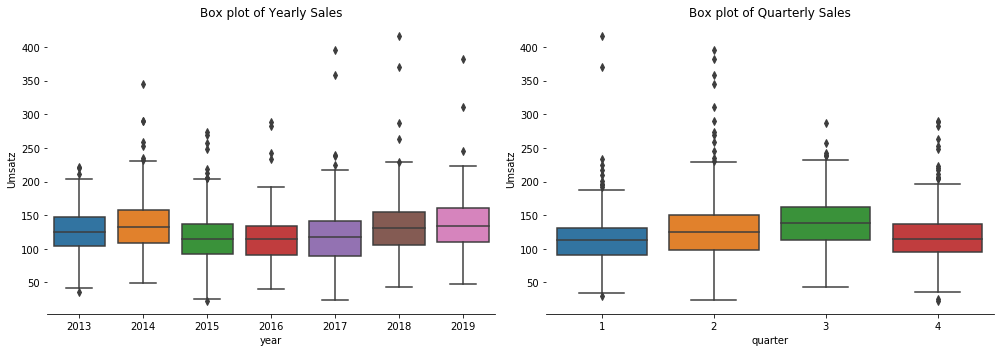

In [112]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Umsatz", data=G1)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Umsatz", data=G1)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout();

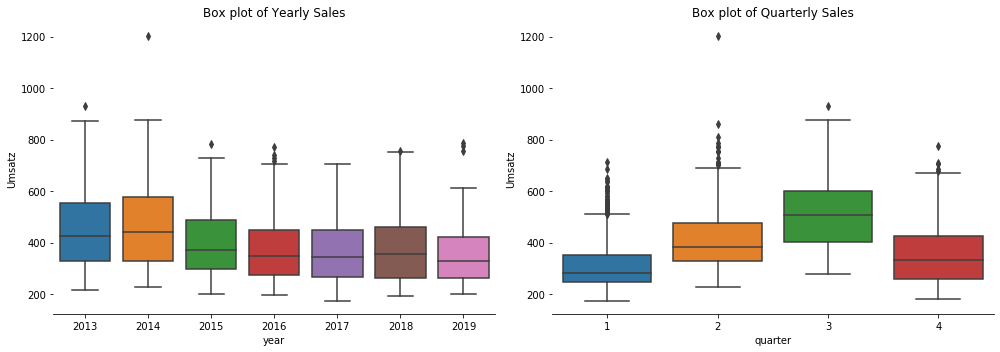

In [113]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Umsatz", data=G2)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Umsatz", data=G2)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout();

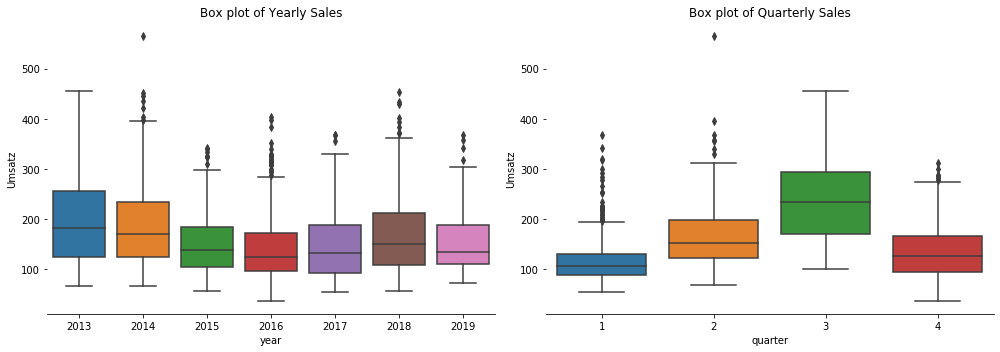

In [114]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Umsatz", data=G3)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Umsatz", data=G3)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout();


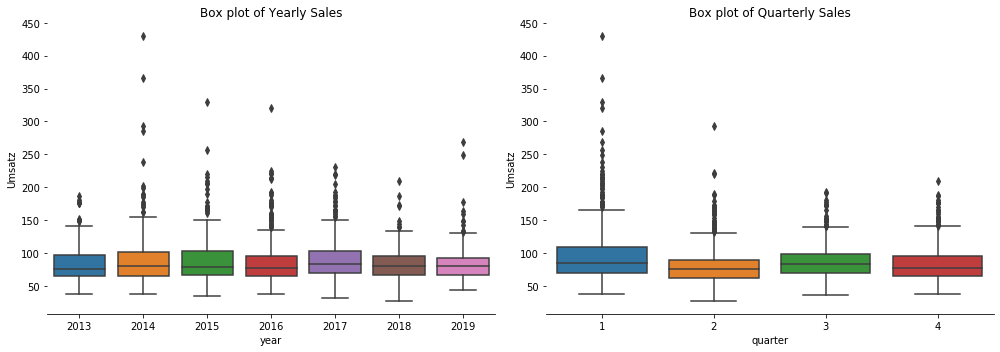

In [115]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Umsatz", data=G4)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Umsatz", data=G4)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout();

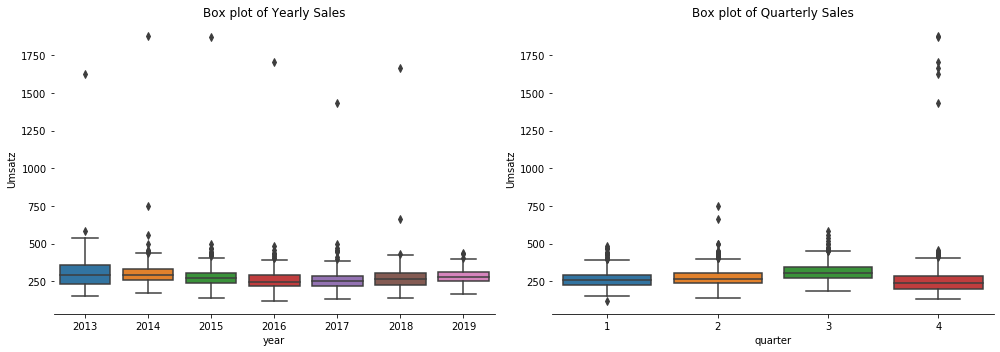

In [116]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Umsatz", data=G5)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Umsatz", data=G5)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout();

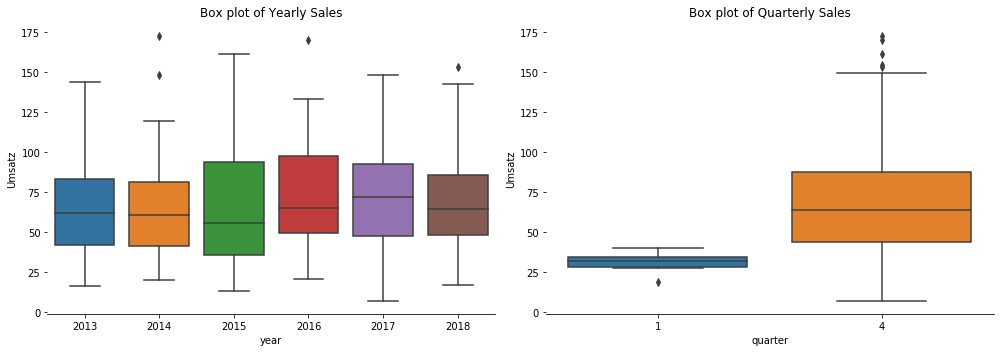

In [117]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Umsatz", data=G6)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Umsatz", data=G6)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout();

count         mean        std     min       25%     50%  \
Umsatz               2090.0   124.250766  40.893937    23.1    98.125   121.7   
Bewoelkung           2090.0     4.697129   2.657151     0.0     2.000     6.0   
Temperatur           2090.0    11.984067   7.191955    -8.5     6.200    11.6   
Windgeschwindigkeit  2090.0    11.038756   4.140187     3.0     8.000    10.0   
KielerWoche          2090.0     0.000000   0.000000     0.0     0.000     0.0   
year                 2090.0  2015.931100   1.756078  2013.0  2014.000  2016.0   
quarter              2090.0     2.500000   1.120440     1.0     1.000     3.0   
month                2090.0     6.481818   3.457034     1.0     3.000     7.0   
day                  2090.0    15.792344   8.752374     1.0     8.000    16.0   
weekday              2090.0     0.714833   0.451602     0.0     0.000     1.0   

                          75%     max  
Umsatz                146.675   416.8  
Bewoelkung              7.000     8.0  
Temperatur             17.800    32.7  
Windgeschwindigkeit    13.000    35.0  
KielerWoche             0.000     0.0  
year                 2017.000  2019.0  
quarter                 3.000     4.0  
month                   9.000    12.0  
day                    23.000    31.0  
weekday                 1.000     1.0

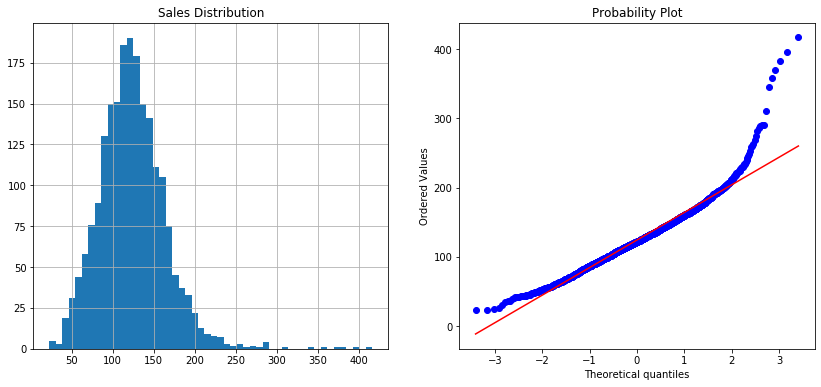

In [121]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
G1['Umsatz'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(G1['Umsatz'], plot=plt);
G1.describe().T

count         mean         std     min     25%     50%  \
Umsatz               2090.0   398.842105  137.425531   175.0   286.5   367.7   
Bewoelkung           2090.0     4.697129    2.657151     0.0     2.0     6.0   
Temperatur           2090.0    11.984067    7.191955    -8.5     6.2    11.6   
Windgeschwindigkeit  2090.0    11.038756    4.140187     3.0     8.0    10.0   
KielerWoche          2090.0     0.000000    0.000000     0.0     0.0     0.0   
year                 2090.0  2015.931100    1.756078  2013.0  2014.0  2016.0   
quarter              2090.0     2.500000    1.120440     1.0     1.0     3.0   
month                2090.0     6.481818    3.457034     1.0     3.0     7.0   
day                  2090.0    15.792344    8.752374     1.0     8.0    16.0   
weekday              2090.0     0.714833    0.451602     0.0     0.0     1.0   

                          75%     max  
Umsatz                485.825  1203.4  
Bewoelkung              7.000     8.0  
Temperatur             17.800    32.7  
Windgeschwindigkeit    13.000    35.0  
KielerWoche             0.000     0.0  
year                 2017.000  2019.0  
quarter                 3.000     4.0  
month                   9.000    12.0  
day                    23.000    31.0  
weekday                 1.000     1.0

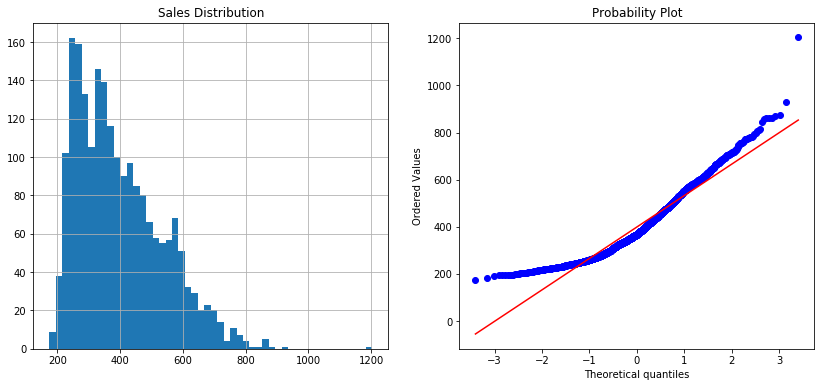

In [122]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
G2['Umsatz'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(G2['Umsatz'], plot=plt);
G2.describe().T

count         mean        std     min     25%     50%  \
Umsatz               2090.0   164.262297  75.408444    37.7   106.6   143.6   
Bewoelkung           2090.0     4.697129   2.657151     0.0     2.0     6.0   
Temperatur           2090.0    11.984067   7.191955    -8.5     6.2    11.6   
Windgeschwindigkeit  2090.0    11.038756   4.140187     3.0     8.0    10.0   
KielerWoche          2090.0     0.000000   0.000000     0.0     0.0     0.0   
year                 2090.0  2015.931100   1.756078  2013.0  2014.0  2016.0   
quarter              2090.0     2.500000   1.120440     1.0     1.0     3.0   
month                2090.0     6.481818   3.457034     1.0     3.0     7.0   
day                  2090.0    15.792344   8.752374     1.0     8.0    16.0   
weekday              2090.0     0.714833   0.451602     0.0     0.0     1.0   

                          75%     max  
Umsatz                204.525   565.9  
Bewoelkung              7.000     8.0  
Temperatur             17.800    32.7  
Windgeschwindigkeit    13.000    35.0  
KielerWoche             0.000     0.0  
year                 2017.000  2019.0  
quarter                 3.000     4.0  
month                   9.000    12.0  
day                    23.000    31.0  
weekday                 1.000     1.0

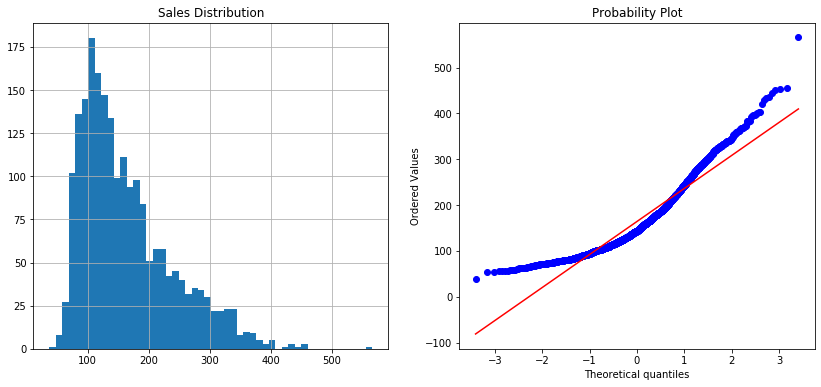

In [123]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
G3['Umsatz'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(G3['Umsatz'], plot=plt);
G3.describe().T

count         mean        std     min     25%     50%  \
Umsatz               2036.0    87.403094  34.338679    27.4    66.2    79.9   
Bewoelkung           2036.0     4.697446   2.666530     0.0     2.0     6.0   
Temperatur           2036.0    11.944253   7.181773    -8.5     6.2    11.6   
Windgeschwindigkeit  2036.0    11.020629   4.139053     3.0     8.0    10.0   
KielerWoche          2036.0     0.000000   0.000000     0.0     0.0     0.0   
year                 2036.0  2015.979371   1.745635  2013.0  2015.0  2016.0   
quarter              2036.0     2.483301   1.122132     1.0     1.0     2.0   
month                2036.0     6.426326   3.453442     1.0     3.0     6.0   
day                  2036.0    15.687132   8.705718     1.0     8.0    16.0   
weekday              2036.0     0.712181   0.452858     0.0     0.0     1.0   

                          75%     max  
Umsatz                 97.425   430.5  
Bewoelkung              7.000     8.0  
Temperatur             17.800    32.7  
Windgeschwindigkeit    13.000    35.0  
KielerWoche             0.000     0.0  
year                 2017.000  2019.0  
quarter                 3.000     4.0  
month                   9.000    12.0  
day                    23.000    31.0  
weekday                 1.000     1.0

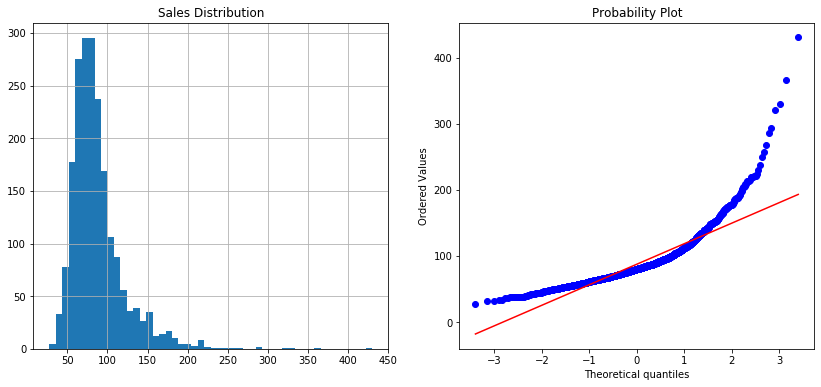

In [124]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
G4['Umsatz'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(G4['Umsatz'], plot=plt);
G4.describe().T

count         mean        std     min     25%      50%  \
Umsatz               2090.0   278.326555  99.502916   121.5   231.4   268.35   
Bewoelkung           2090.0     4.697129   2.657151     0.0     2.0     6.00   
Temperatur           2090.0    11.984067   7.191955    -8.5     6.2    11.60   
Windgeschwindigkeit  2090.0    11.038756   4.140187     3.0     8.0    10.00   
KielerWoche          2090.0     0.000000   0.000000     0.0     0.0     0.00   
year                 2090.0  2015.931100   1.756078  2013.0  2014.0  2016.00   
quarter              2090.0     2.500000   1.120440     1.0     1.0     3.00   
month                2090.0     6.481818   3.457034     1.0     3.0     7.00   
day                  2090.0    15.792344   8.752374     1.0     8.0    16.00   
weekday              2090.0     0.714833   0.451602     0.0     0.0     1.00   

                        75%     max  
Umsatz                308.7  1879.5  
Bewoelkung              7.0     8.0  
Temperatur             17.8    32.7  
Windgeschwindigkeit    13.0    35.0  
KielerWoche             0.0     0.0  
year                 2017.0  2019.0  
quarter                 3.0     4.0  
month                   9.0    12.0  
day                    23.0    31.0  
weekday                 1.0     1.0

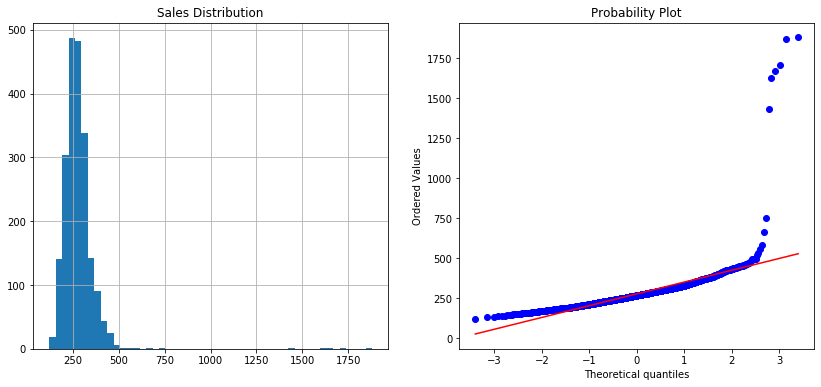

In [125]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
G5['Umsatz'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(G5['Umsatz'], plot=plt);
G5.describe().T

count         mean        std     min       25%      50%  \
Umsatz               338.0    67.859763  32.015524     7.1    43.425    63.55   
Bewoelkung           338.0     5.807692   2.231751     0.0     5.000     7.00   
Temperatur           338.0     6.576923   3.477601    -3.0     4.500     6.20   
Windgeschwindigkeit  338.0    10.254438   4.227969     3.0     7.000    10.00   
KielerWoche          338.0     0.000000   0.000000     0.0     0.000     0.00   
year                 338.0  2015.363905   1.736533  2013.0  2014.000  2015.00   
quarter              338.0     3.946746   0.396728     1.0     4.000     4.00   
month                338.0    11.254438   1.489945     1.0    11.000    11.00   
day                  338.0    15.508876   8.608614     1.0     8.000    15.00   
weekday              338.0     0.715976   0.451617     0.0     0.000     1.00   

                          75%     max  
Umsatz                 87.025   172.9  
Bewoelkung              7.000     8.0  
Temperatur              8.900    16.8  
Windgeschwindigkeit    12.000    25.0  
KielerWoche             0.000     0.0  
year                 2017.000  2018.0  
quarter                 4.000     4.0  
month                  12.000    12.0  
day                    23.000    31.0  
weekday                 1.000     1.0

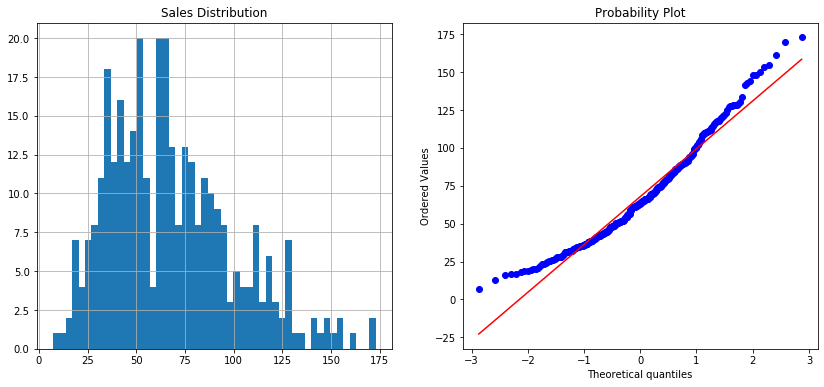

In [126]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
G6['Umsatz'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(G6['Umsatz'], plot=plt);
G6.describe().T

C:\Users\Jibra\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


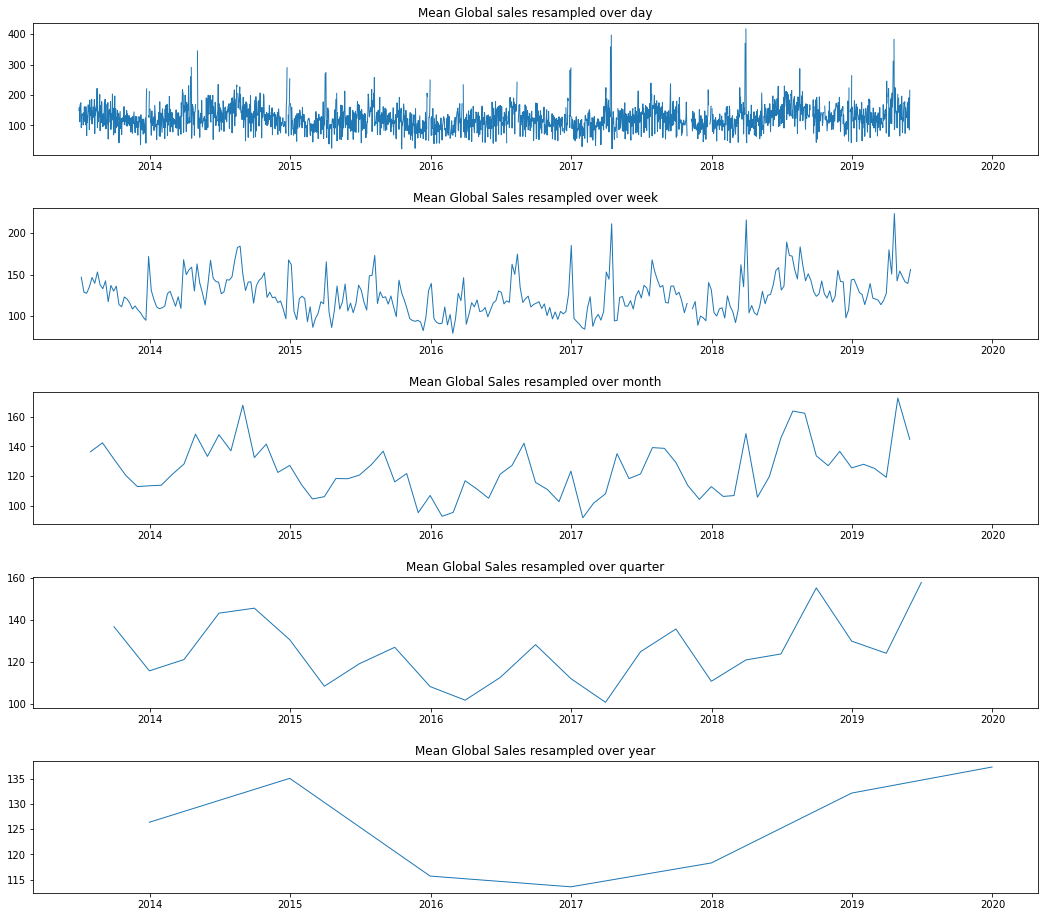

In [127]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(G1['Umsatz'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(G1['Umsatz'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(G1['Umsatz'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(G1['Umsatz'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(G1['Umsatz'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global Sales resampled over year')
ax5.tick_params(axis='both', which='major');

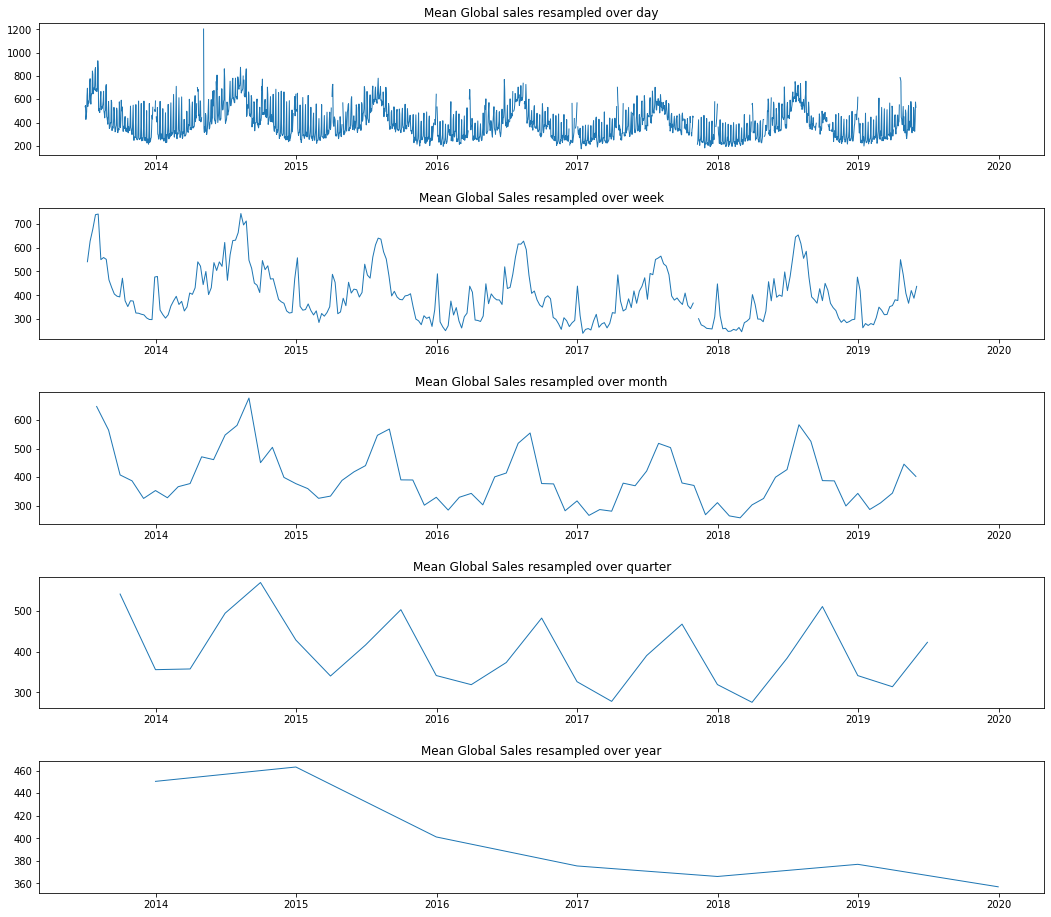

In [128]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(G2['Umsatz'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(G2['Umsatz'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(G2['Umsatz'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(G2['Umsatz'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(G2['Umsatz'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global Sales resampled over year')
ax5.tick_params(axis='both', which='major');

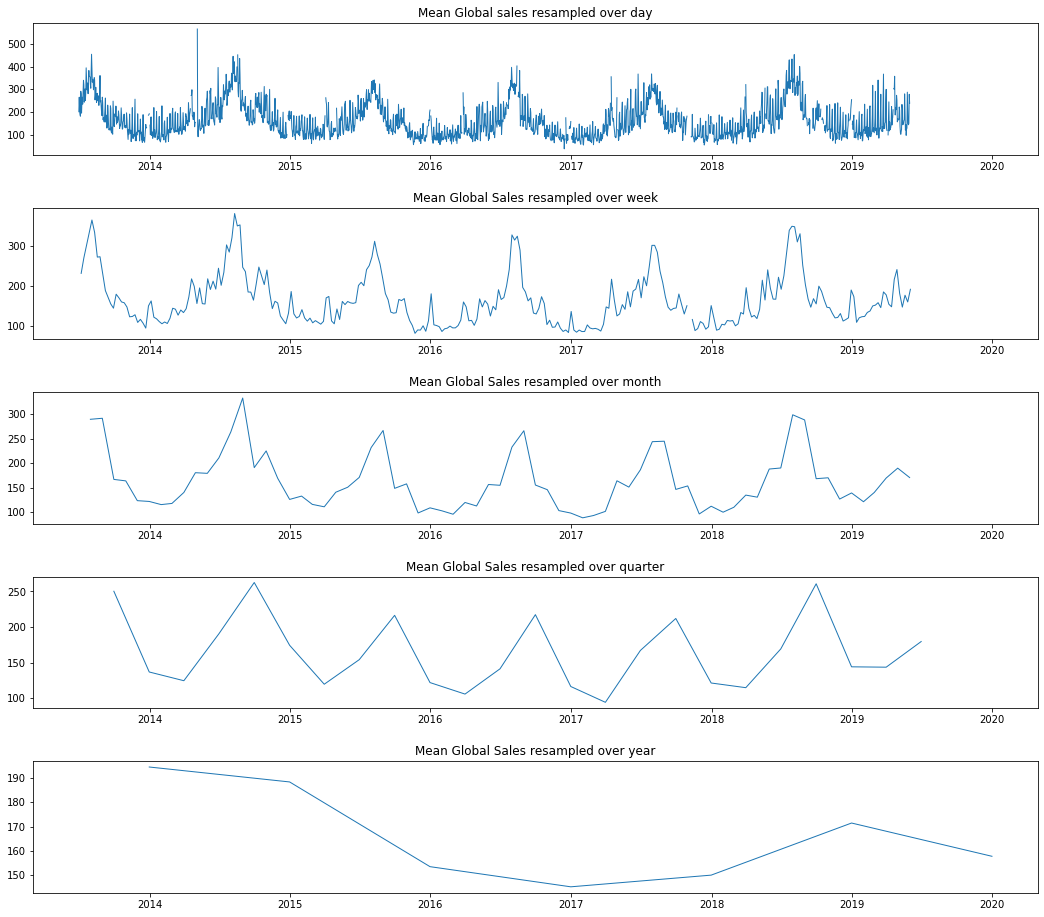

In [129]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(G3['Umsatz'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(G3['Umsatz'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(G3['Umsatz'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(G3['Umsatz'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(G3['Umsatz'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global Sales resampled over year')
ax5.tick_params(axis='both', which='major');

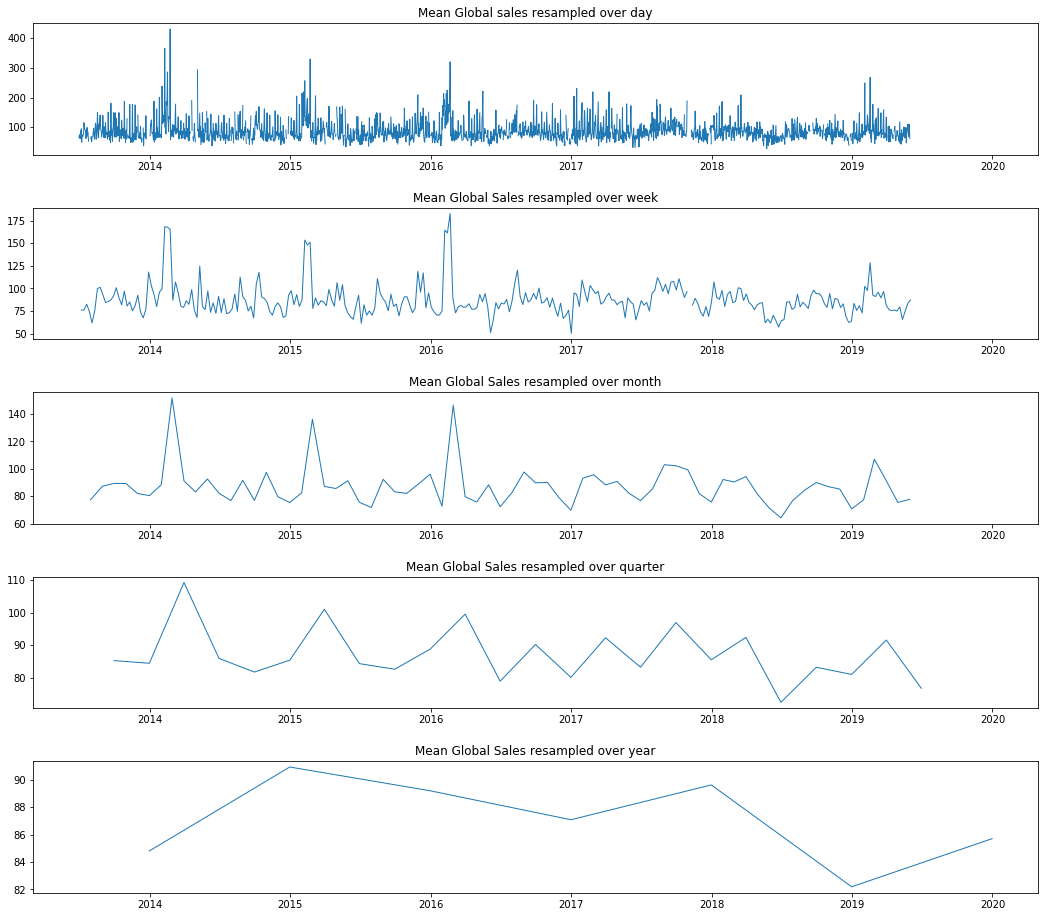

In [130]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(G4['Umsatz'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(G4['Umsatz'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(G4['Umsatz'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(G4['Umsatz'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(G4['Umsatz'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global Sales resampled over year')
ax5.tick_params(axis='both', which='major');

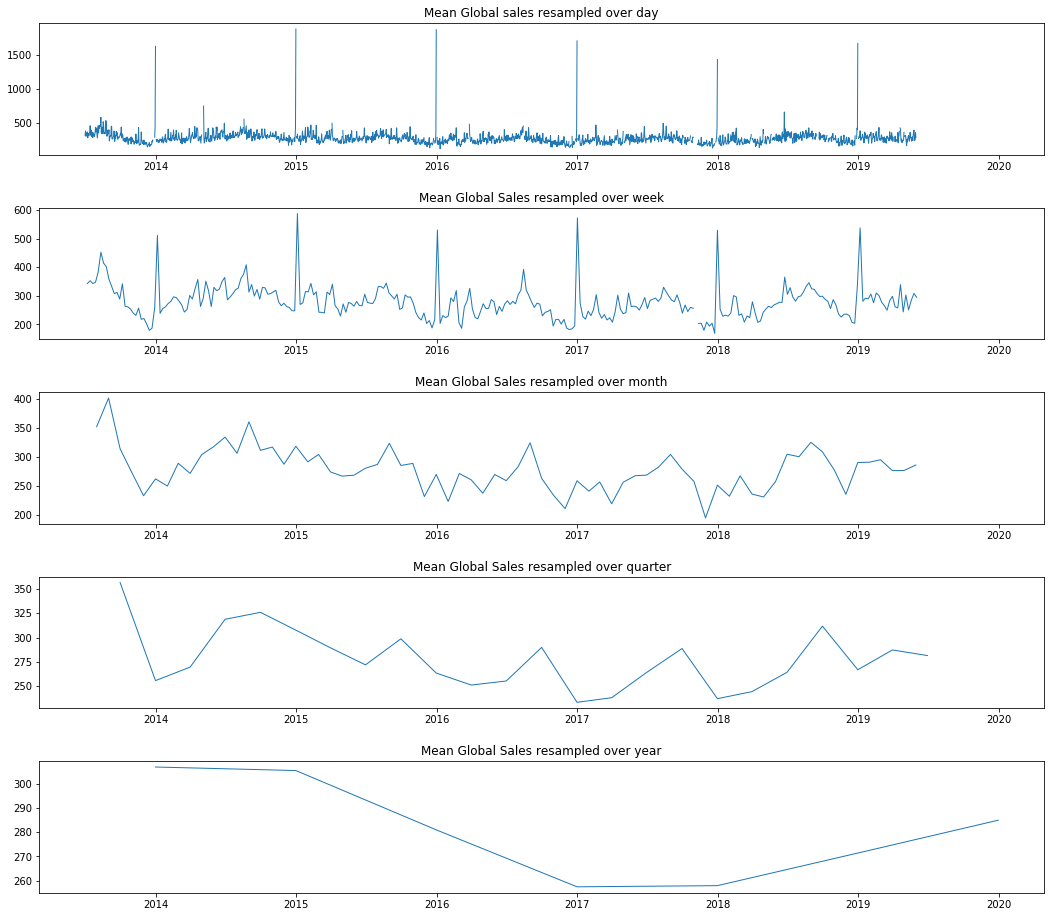

In [131]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(G5['Umsatz'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(G5['Umsatz'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(G5['Umsatz'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(G5['Umsatz'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(G5['Umsatz'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global Sales resampled over year')
ax5.tick_params(axis='both', which='major');

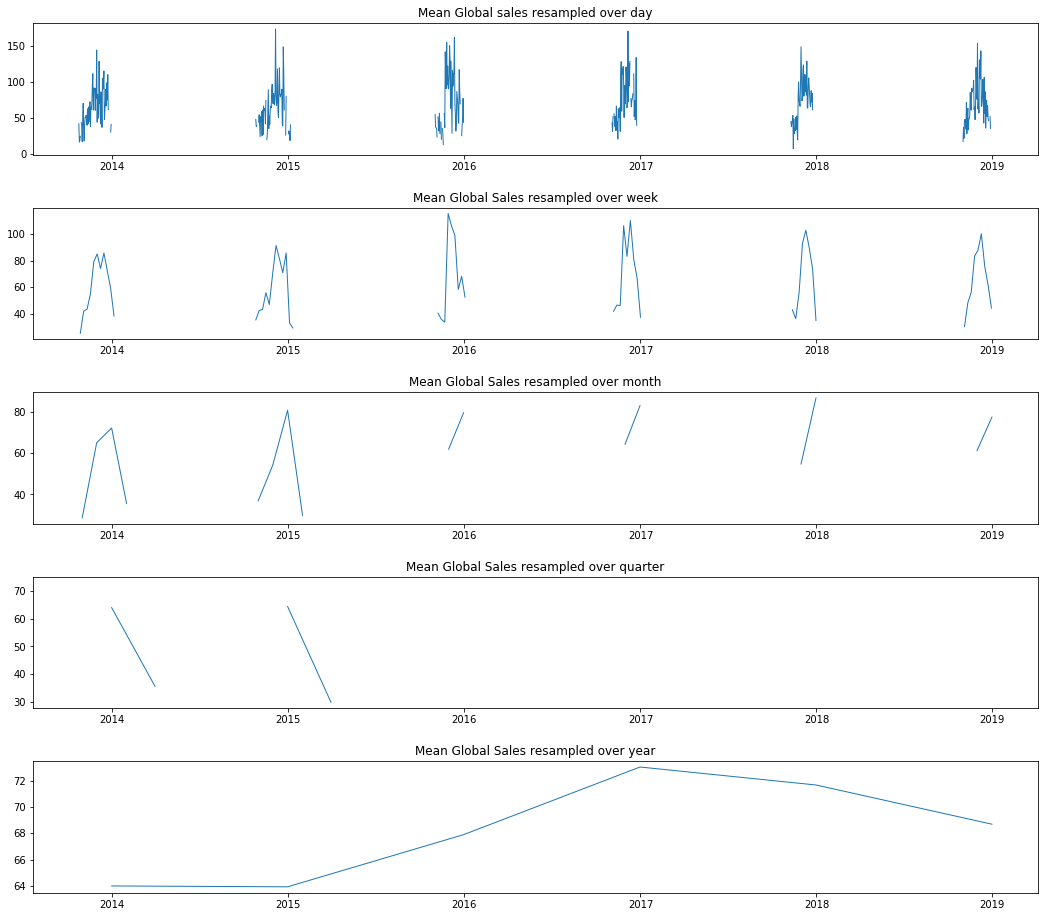

In [132]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(G6['Umsatz'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(G6['Umsatz'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(G6['Umsatz'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(G6['Umsatz'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(G6['Umsatz'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global Sales resampled over year')
ax5.tick_params(axis='both', which='major');

Text(0.5, 1.0, 'Mean Sales by Day')

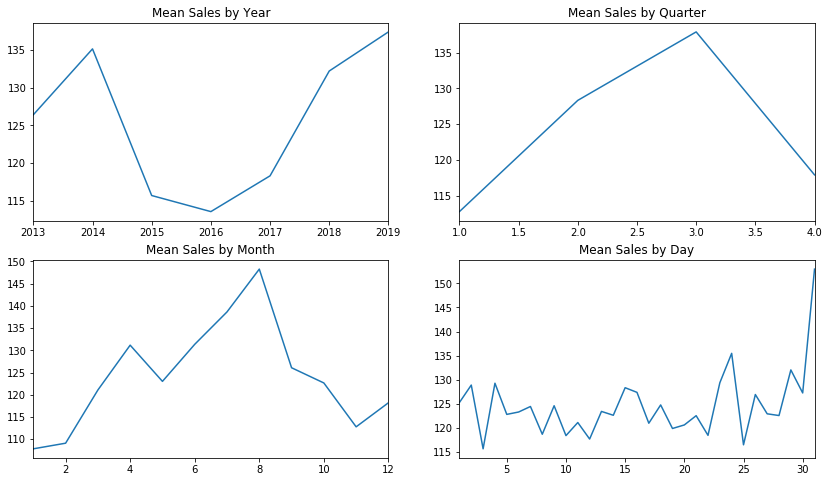

In [133]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
G1.groupby('year').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
G1.groupby('quarter').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
G1.groupby('month').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
G1.groupby('day').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day')

Text(0.5, 1.0, 'Mean Sales by Day')

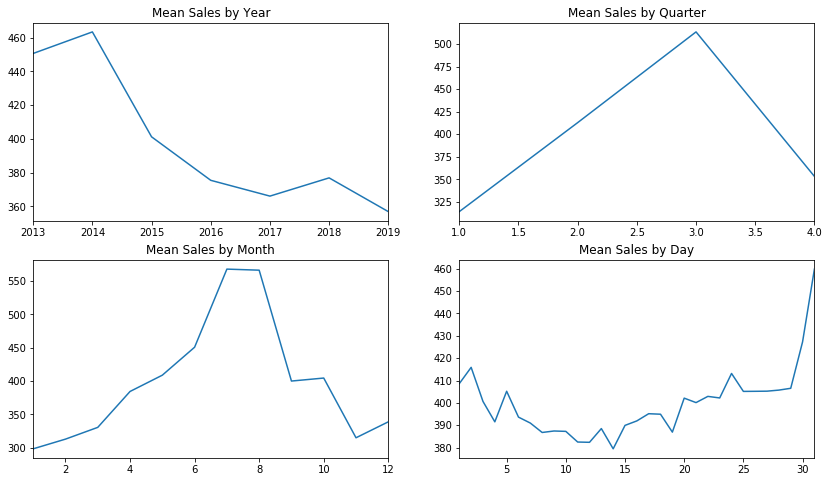

In [134]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
G2.groupby('year').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
G2.groupby('quarter').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
G2.groupby('month').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
G2.groupby('day').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day')

Text(0.5, 1.0, 'Mean Sales by Day')

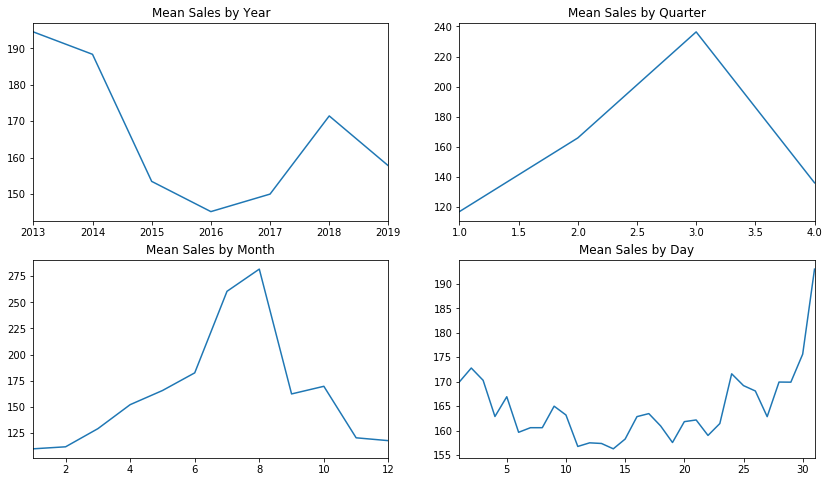

In [135]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
G3.groupby('year').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
G3.groupby('quarter').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
G3.groupby('month').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
G3.groupby('day').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day')

Text(0.5, 1.0, 'Mean Sales by Day')

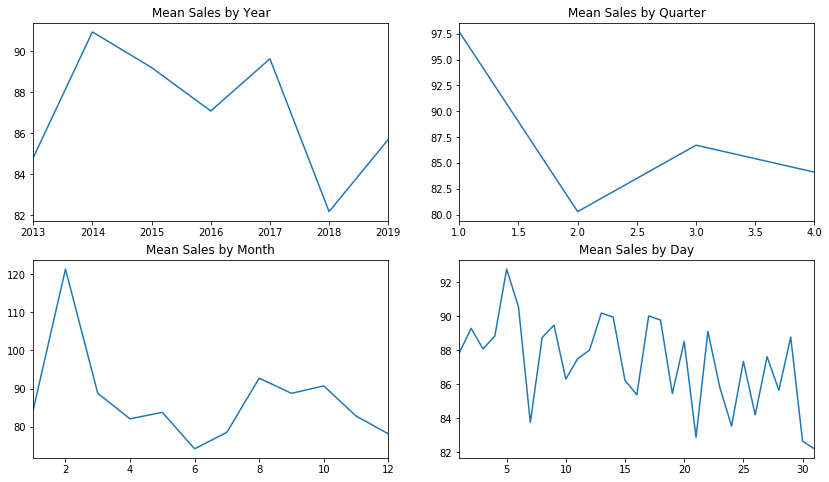

In [136]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
G4.groupby('year').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
G4.groupby('quarter').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
G4.groupby('month').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
G4.groupby('day').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day')

Text(0.5, 1.0, 'Mean Sales by Day')

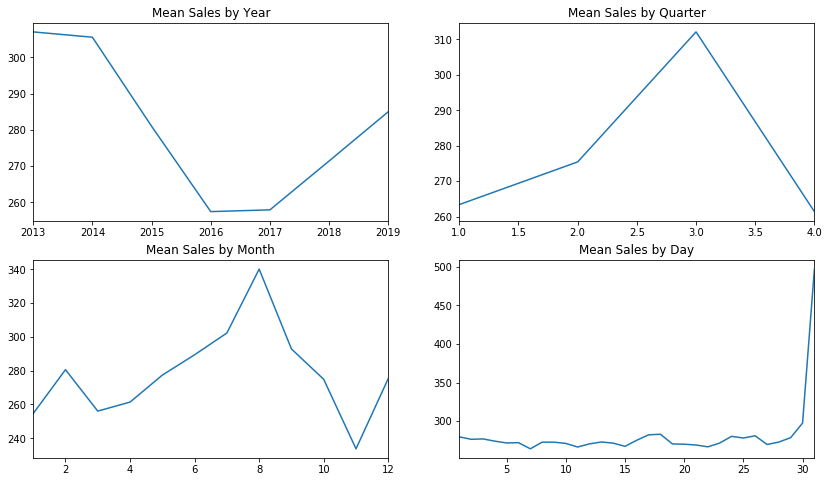

In [137]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
G5.groupby('year').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
G5.groupby('quarter').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
G5.groupby('month').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
G5.groupby('day').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day')

Text(0.5, 1.0, 'Mean Sales by Day')

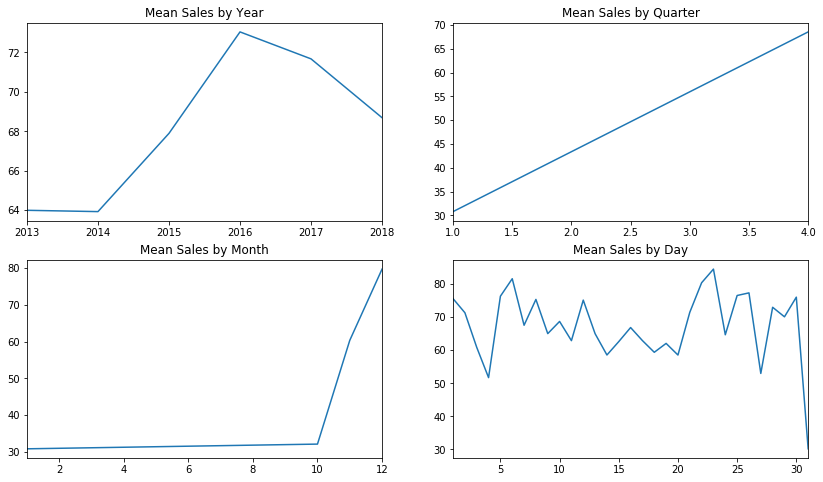

In [138]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
G6.groupby('year').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
G6.groupby('quarter').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
G6.groupby('month').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
G6.groupby('day').Umsatz.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day')

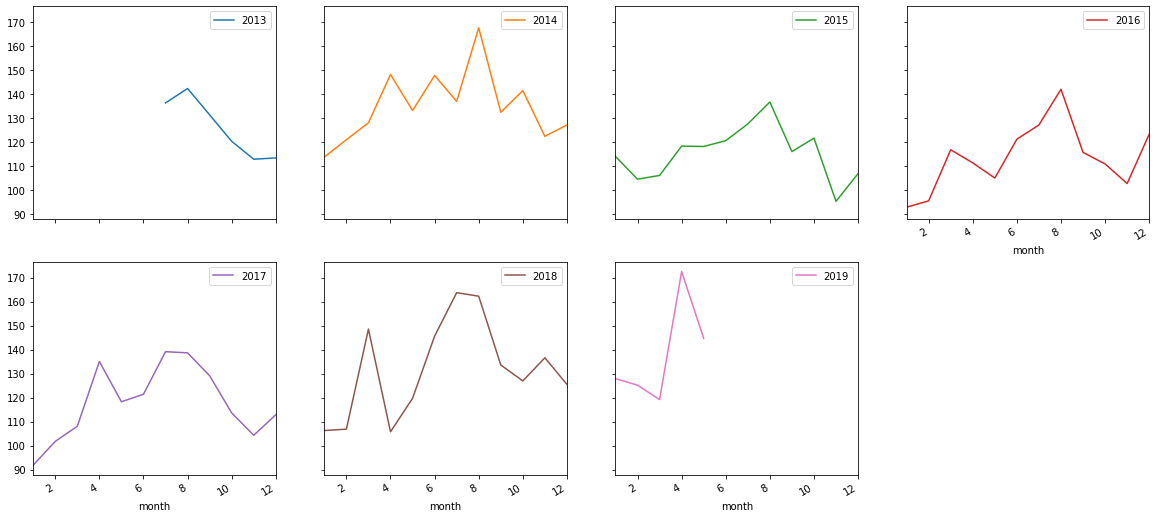

In [139]:
pd.pivot_table(G1, values = "Umsatz", 
               columns = "year", index = "month").plot(subplots = True, figsize=(20, 20), layout=(4, 4), sharey=True);

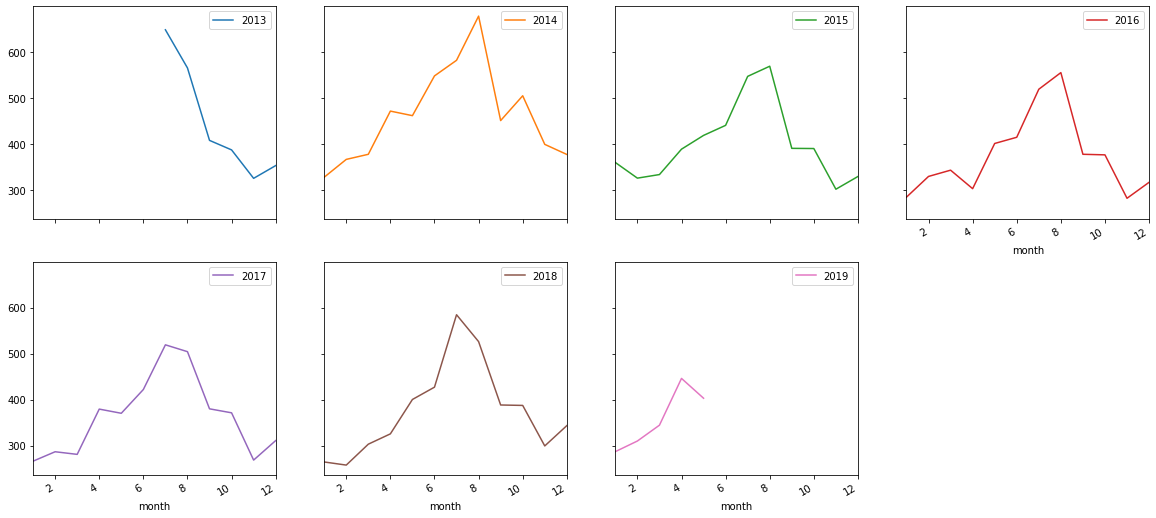

In [140]:
pd.pivot_table(G2, values = "Umsatz", 
               columns = "year", index = "month").plot(subplots = True, figsize=(20, 20), layout=(4, 4), sharey=True);

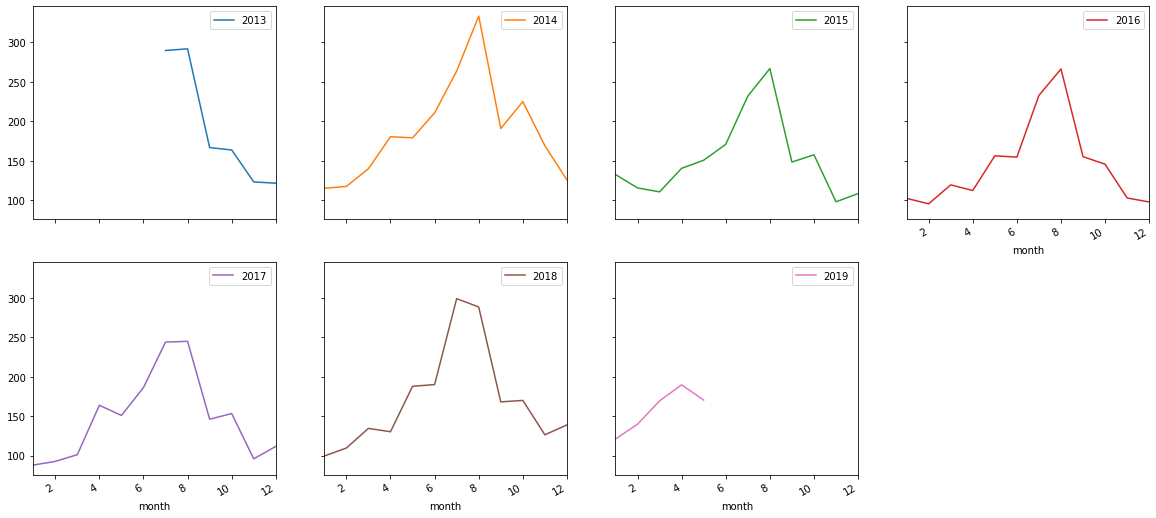

In [141]:
pd.pivot_table(G3, values = "Umsatz", 
               columns = "year", index = "month").plot(subplots = True, figsize=(20, 20), layout=(4, 4), sharey=True);

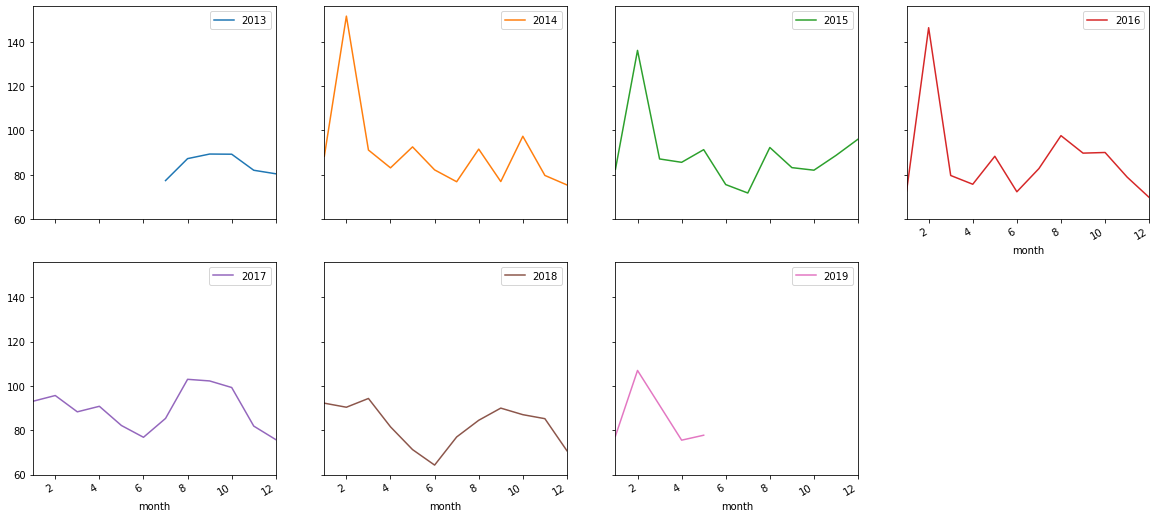

In [142]:
pd.pivot_table(G4, values = "Umsatz", 
               columns = "year", index = "month").plot(subplots = True, figsize=(20, 20), layout=(4, 4), sharey=True);

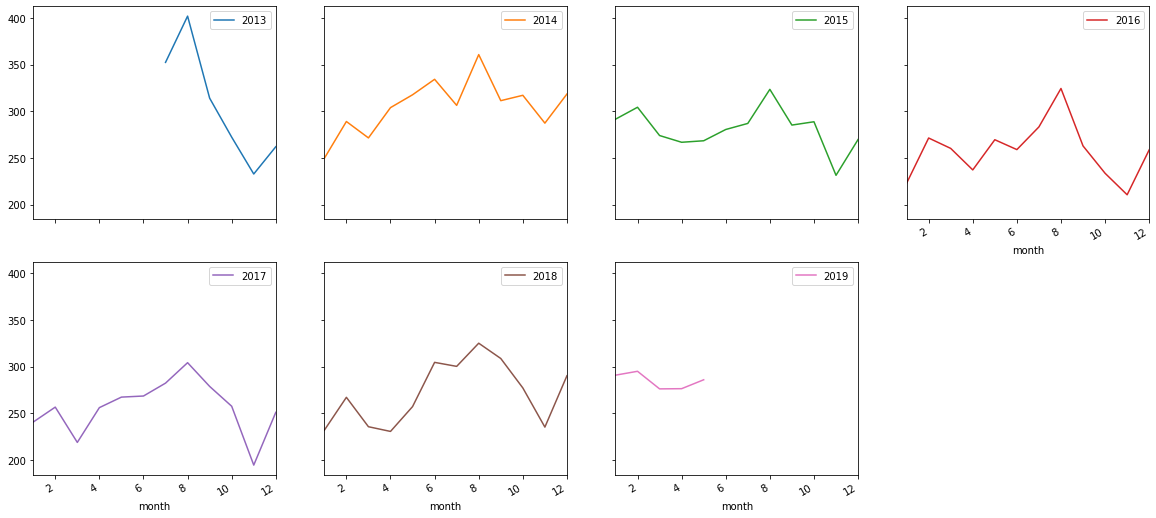

In [143]:
pd.pivot_table(G5, values = "Umsatz", 
               columns = "year", index = "month").plot(subplots = True, figsize=(20, 20), layout=(4, 4), sharey=True);

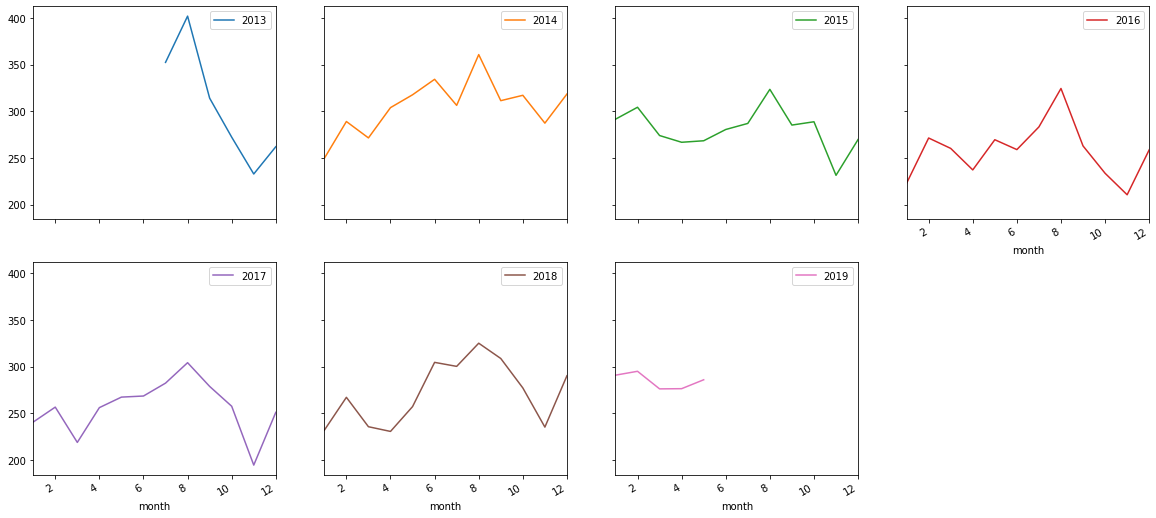

In [144]:
pd.pivot_table(G5, values = "Umsatz", 
               columns = "year", index = "month").plot(subplots = True, figsize=(20, 20), layout=(4, 4), sharey=True);

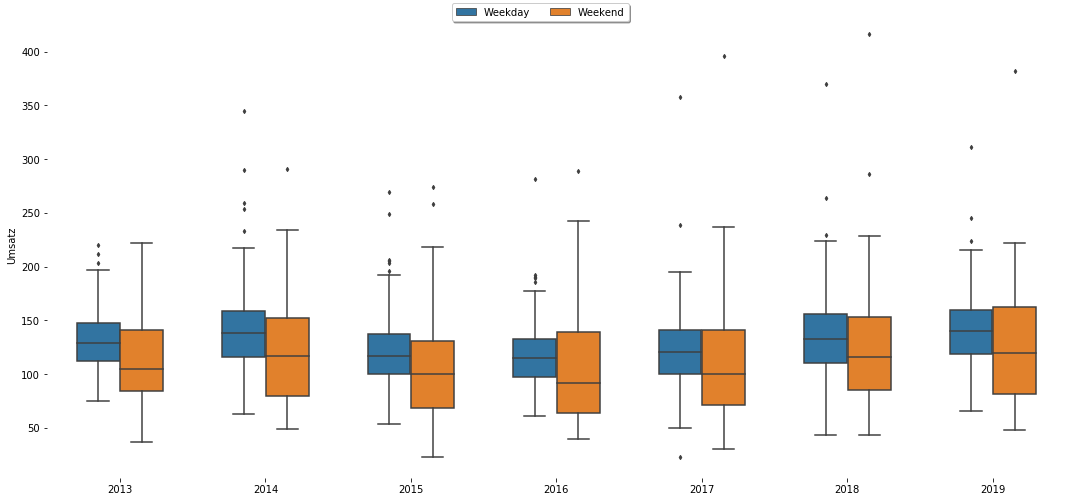

In [145]:
dic={0:'Weekend',1:'Weekday'}
G1['Day'] = G1.weekday.map(dic)
a=plt.figure(figsize=(15,7)) 
plt1=sns.boxplot('year','Umsatz',hue='Day',width=0.6,fliersize=3,
                    data=G1)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

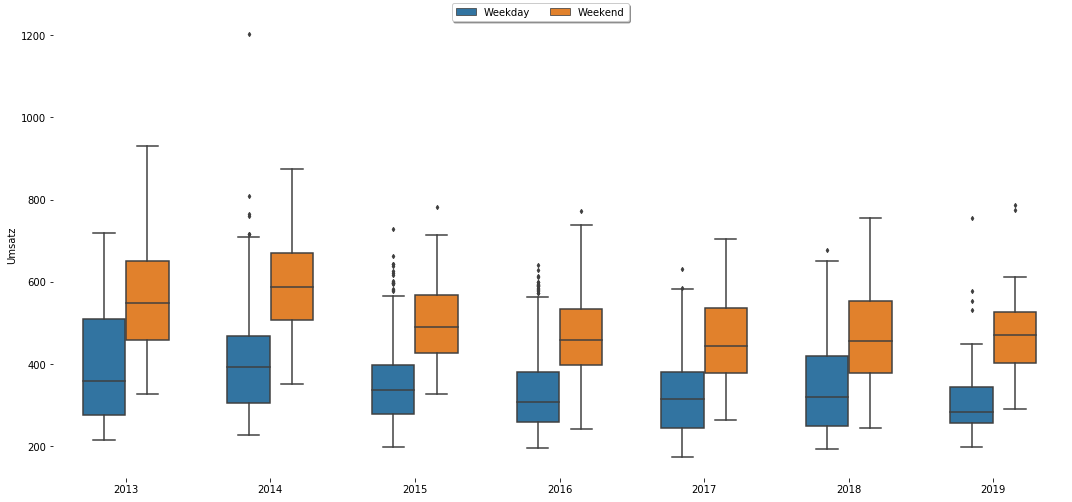

In [146]:
dic={0:'Weekend',1:'Weekday'}
G2['Day'] = G2.weekday.map(dic)
a=plt.figure(figsize=(15,7)) 
plt1=sns.boxplot('year','Umsatz',hue='Day',width=0.6,fliersize=3,
                    data=G2)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

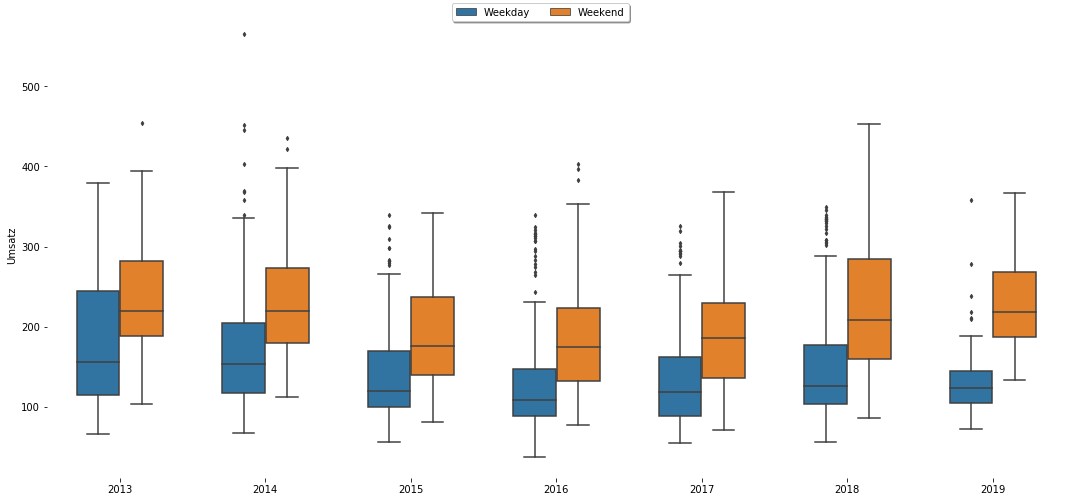

In [147]:
dic={0:'Weekend',1:'Weekday'}
G3['Day'] = G3.weekday.map(dic)
a=plt.figure(figsize=(15,7)) 
plt1=sns.boxplot('year','Umsatz',hue='Day',width=0.6,fliersize=3,
                    data=G3)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

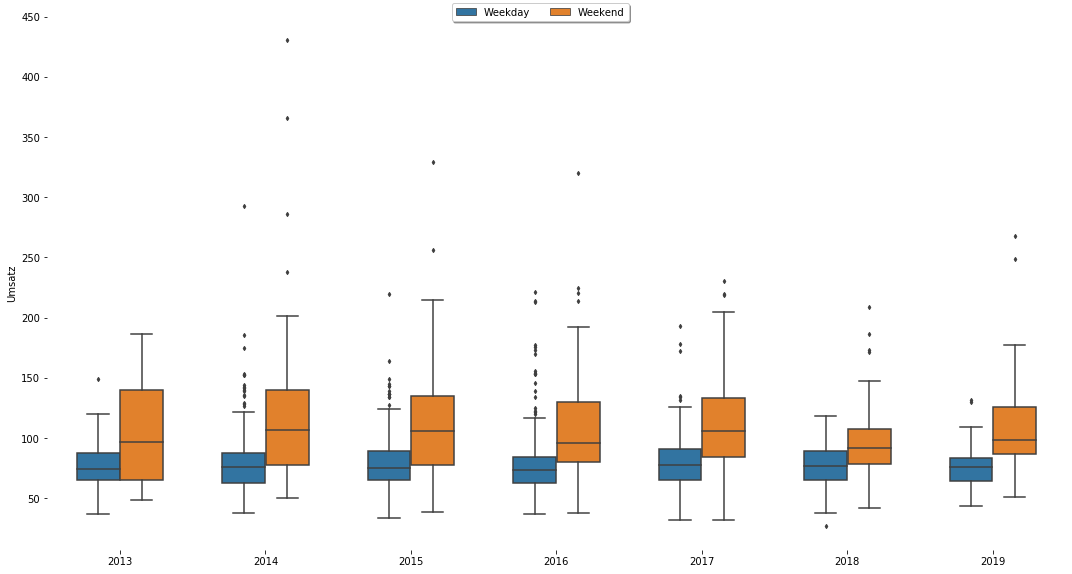

In [148]:
dic={0:'Weekend',1:'Weekday'}
G4['Day'] = G4.weekday.map(dic)
a=plt.figure(figsize=(15,8)) 
plt1=sns.boxplot('year','Umsatz',hue='Day',width=0.6,fliersize=3,
                    data=G4)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

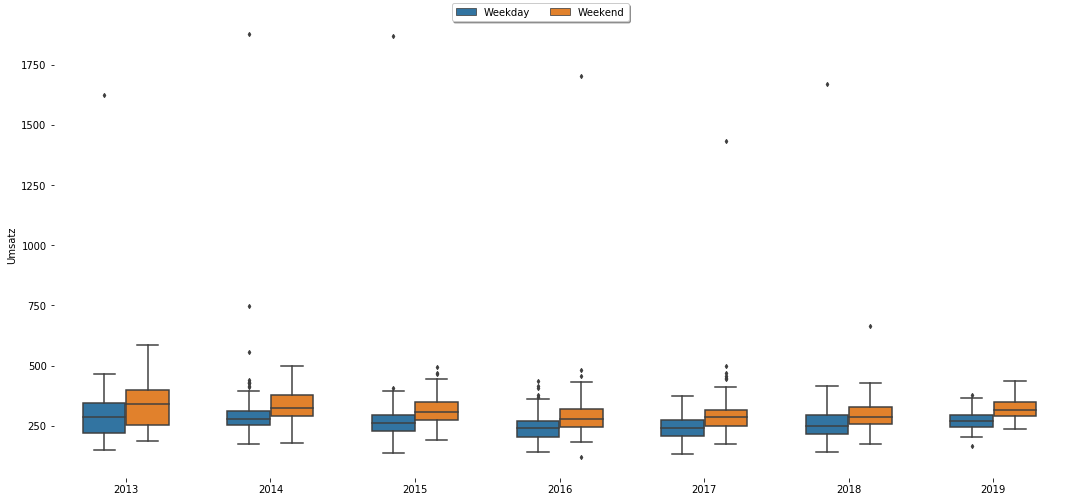

In [149]:
dic={0:'Weekend',1:'Weekday'}
G5['Day'] = G5.weekday.map(dic)
a=plt.figure(figsize=(15,7)) 
plt1=sns.boxplot('year','Umsatz',hue='Day',width=0.6,fliersize=3,
                    data=G5)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


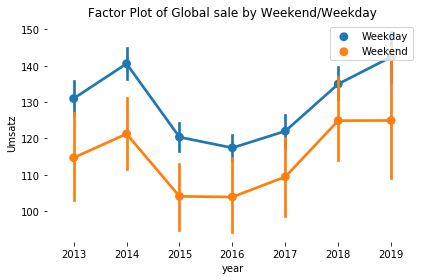

In [150]:
plt1=sns.factorplot('year','Umsatz',hue='Day',
                    data=G1, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global sale by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


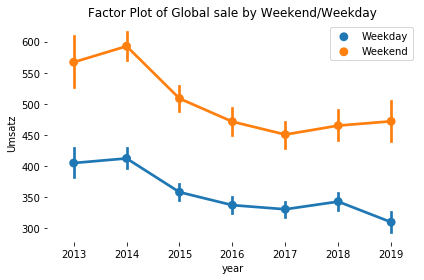

In [151]:
plt1=sns.factorplot('year','Umsatz',hue='Day',
                    data=G2, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global sale by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


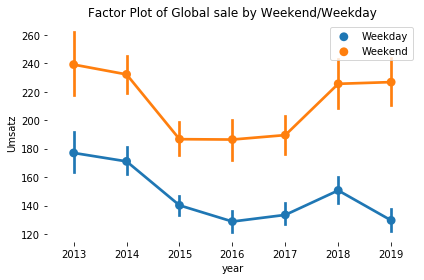

In [152]:
plt1=sns.factorplot('year','Umsatz',hue='Day',
                    data=G3, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global sale by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


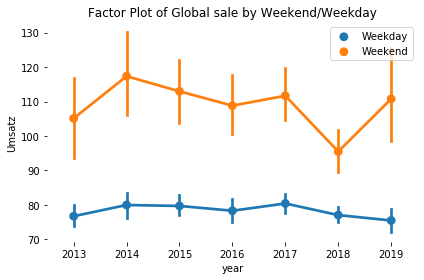

In [153]:
plt1=sns.factorplot('year','Umsatz',hue='Day',
                    data=G4, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global sale by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Jibra\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


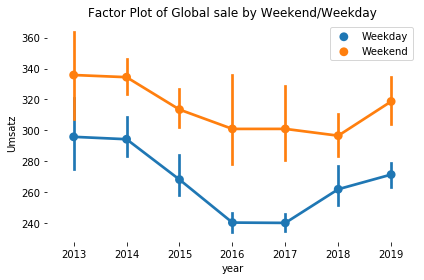

In [154]:
plt1=sns.factorplot('year','Umsatz',hue='Day',
                    data=G5, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global sale by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

C:\Users\Jibra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


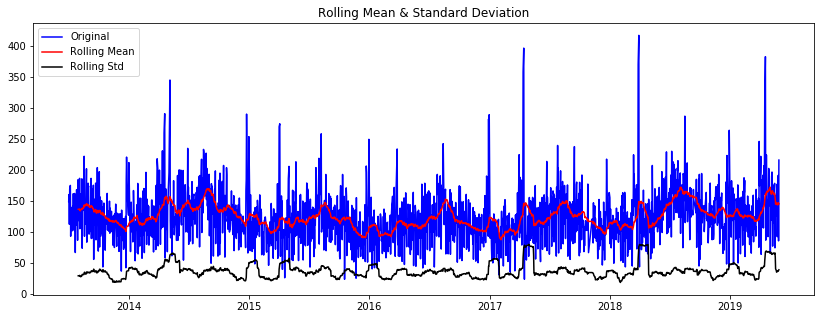

<Results of Dickey-Fuller Test>
Test Statistic                -6.016214e+00
p-value                        1.531506e-07
#Lags Used                     2.000000e+01
Number of Observations Used    2.069000e+03
Critical Value (1%)           -3.433515e+00
Critical Value (5%)           -2.862938e+00
Critical Value (10%)          -2.567514e+00
dtype: float64


In [159]:
df2=G1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Umsatz.dropna())

C:\Users\Jibra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


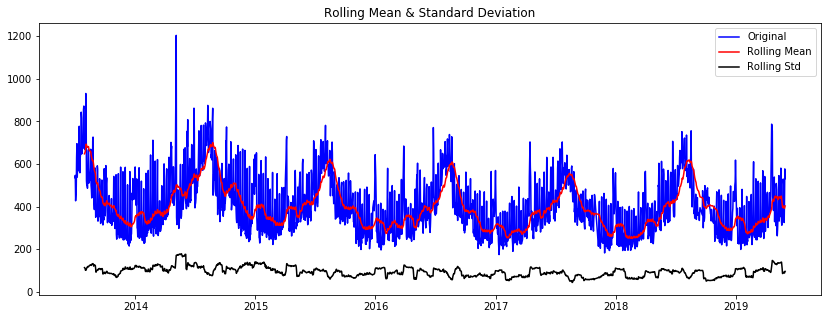

<Results of Dickey-Fuller Test>
Test Statistic                   -4.452324
p-value                           0.000240
#Lags Used                       21.000000
Number of Observations Used    2068.000000
Critical Value (1%)              -3.433516
Critical Value (5%)              -2.862939
Critical Value (10%)             -2.567515
dtype: float64


In [160]:
test_stationarity(G2.resample('D', how=np.mean).Umsatz.dropna())

C:\Users\Jibra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


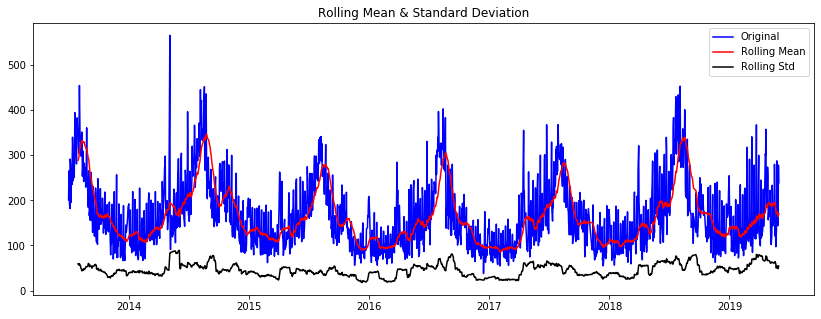

<Results of Dickey-Fuller Test>
Test Statistic                   -4.572887
p-value                           0.000145
#Lags Used                       21.000000
Number of Observations Used    2068.000000
Critical Value (1%)              -3.433516
Critical Value (5%)              -2.862939
Critical Value (10%)             -2.567515
dtype: float64


In [161]:
test_stationarity(G3.resample('D', how=np.mean).Umsatz.dropna())

C:\Users\Jibra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


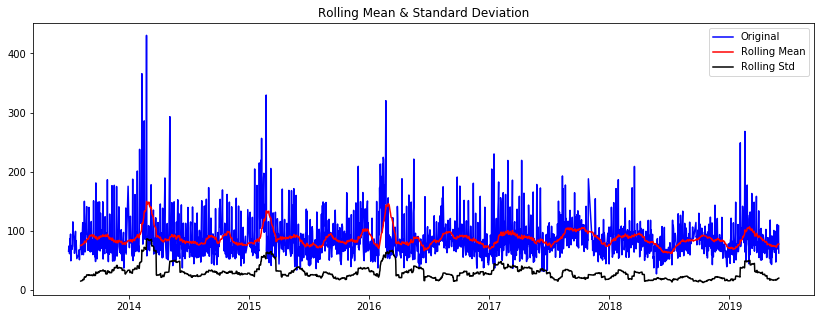

<Results of Dickey-Fuller Test>
Test Statistic                -8.053819e+00
p-value                        1.713684e-12
#Lags Used                     2.100000e+01
Number of Observations Used    2.014000e+03
Critical Value (1%)           -3.433601e+00
Critical Value (5%)           -2.862976e+00
Critical Value (10%)          -2.567535e+00
dtype: float64


In [162]:
test_stationarity(G4.resample('D', how=np.mean).Umsatz.dropna())

C:\Users\Jibra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


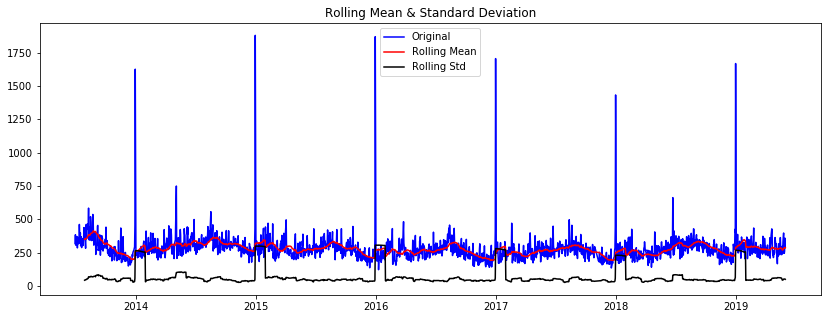

<Results of Dickey-Fuller Test>
Test Statistic                -8.129162e+00
p-value                        1.102162e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.076000e+03
Critical Value (1%)           -3.433504e+00
Critical Value (5%)           -2.862933e+00
Critical Value (10%)          -2.567512e+00
dtype: float64


In [163]:
test_stationarity(G5.resample('D', how=np.mean).Umsatz.dropna())

C:\Users\Jibra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


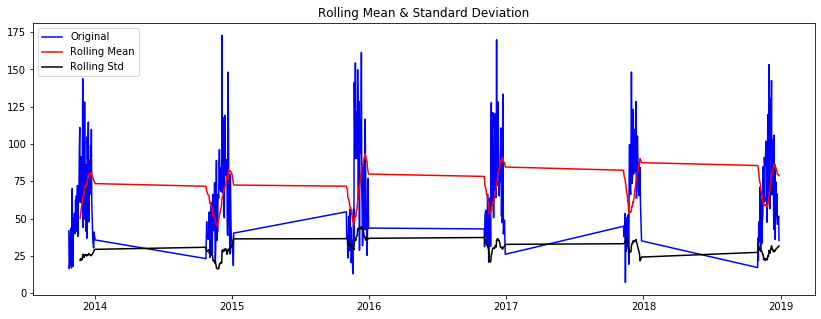

<Results of Dickey-Fuller Test>
Test Statistic                  -5.396178
p-value                          0.000003
#Lags Used                      17.000000
Number of Observations Used    320.000000
Critical Value (1%)             -3.450952
Critical Value (5%)             -2.870615
Critical Value (10%)            -2.571605
dtype: float64


In [164]:
test_stationarity(G6.resample('D', how=np.mean).Umsatz.dropna())